In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import tangram as tg
import muon as mu
import anndata as ad
import nichepca as npc
import scipy.sparse as sparse

import os
import sys
from pathlib import Path

# Add the src directory to the path if it's not already there
notebook_dir = Path(os.getcwd())
if notebook_dir.name == 'src':
    sys.path.append(".")  # Add current directory
else:
    sys.path.append(str(notebook_dir / "src"))  # Add src directory

from config import H5AD_DIR, get_h5ad_path

%load_ext autoreload
%autoreload 2
%matplotlib inline

/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata

In [2]:
# read ad objects
ad_sp = sc.read_h5ad(get_h5ad_path("spatial_filtered.h5ad"))
ad_sc = sc.read_h5ad(get_h5ad_path("subsetted_sc.h5ad"))
ad_atac = sc.read_h5ad(get_h5ad_path("atac_with_correct_barcodes.h5ad"))
ad_map = sc.read_h5ad(get_h5ad_path("newest_ad_map.h5ad"))

In [10]:
ad_atac_sp = sc.read_h5ad(get_h5ad_path("atac_spatial.h5ad"))

In [33]:
ad_atac_sp.var

,chrom,start,end,Strand,n_cells,is_training
0610009b22rik,chr11,51685384,51688634,-,54,False
0610009l18rik,chr11,120348677,120351190,+,133,False
0610010f05rik,chr11,23564948,23633631,-,289,False
0610010k14rik,chr11,70235203,70237914,-,84,False
0610012g03rik,chr16,31947049,31948505,-,72,False
...,...,...,...,...,...,...
zyg11a,chr4,108181933,108218043,-,27,False
zyg11b,chr4,108227754,108301090,-,197,False
zyx,chr6,42349827,42360213,+,258,False
zzef1,chr11,72796225,72927120,+,405,False


In [57]:
ad_atac_sp.var.iloc[14059]

chrom            chr19
start          5970233
end            5986143
Strand               -
n_cells             18
is_training      False
Name: slc22a20, dtype: object

lgi3, lgi2, lgi1

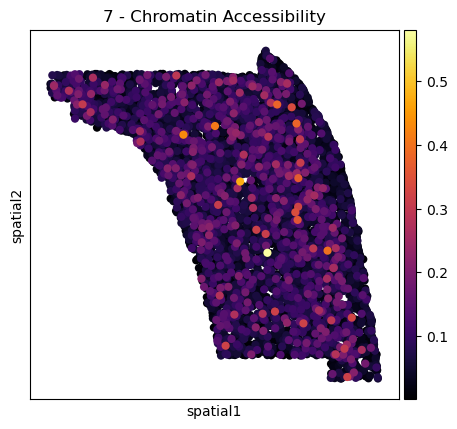

In [59]:
sc.pl.spatial(ad_atac_sp, color="lgi2", 
                     size=10, spot_size=7, 
                     #vmin=vmin, vmax=vmax,
                     cmap="inferno",

                     title=f"{7} - Chromatin Accessibility")

In [3]:
# remove cells with missing spatial data
valid_coords = ~np.isnan(ad_sp.obsm['spatial'][:, 0]) & ~np.isnan(ad_sp.obsm['spatial'][:, 1])

# Filter the AnnData object to keep only cells with valid coordinates
ad_sp = ad_sp[valid_coords]

In [ ]:
# For gene activity scores - each plot normalized to its own range
for gene in genes_of_interest:
    if gene in gene_activity_spatial.var_names:
        # Get values for this gene
        values = gene_activity_spatial[:, gene].X
        if hasattr(values, 'toarray'):
            values = values.toarray().flatten()
        
        # Set range to min and max of this gene
        vmin = np.min(values)
        vmax = np.max(values)
        
        # Plot with range normalized to this specific gene
        sc.pl.spatial(gene_activity_spatial, color=gene, 
                     size=10, spot_size=7, 
                     vmin=vmin, vmax=vmax,
                     cmap="inferno",

                     title=f"{gene} - Chromatin Accessibility")

In [4]:
ad_sp_sparse = ad_sp.copy()

# Convert the X matrix to a scipy sparse matrix (CSR format is commonly used)
# If your data is already normalized and you want to keep it that way
ad_sp_sparse.X = sparse.csr_matrix(ad_sp.X)

npc.wf.nichepca(ad_sp_sparse, knn=25)

----------- Graph Stats -----------
Number of nodes: 5283
Number of edges: 149393
Average in-degree: 28.278060913085938
Average out-degree: 28.278060913085938
Contains self-loops: True
Is undirected: True
Running pipeline: norm->log1p->agg->pca


In [5]:
ad_sp_sparse

AnnData object with n_obs × n_vars = 5283 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'cell_id', 'centroid_x', 'centroid_y'
    uns: 'subclass_colors', 'graph', 'log1p', 'pca', 'npca'
    obsm: 'spatial', 'X_npca'

In [6]:
ad_sp

View of AnnData object with n_obs × n_vars = 5283 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'cell_id', 'centroid_x', 'centroid_y'
    uns: 'subclass_colors'
    obsm: 'spatial'

In [7]:

# Construct a neighborhood graph based on the nichePCA representation
sc.pp.neighbors(ad_sp_sparse, use_rep="X_npca")

# Run Leiden clustering to identify spatial domains
sc.tl.leiden(ad_sp_sparse, resolution=0.5)

In [ ]:
sc.pl.spatial(ad_sp_sparse, color="leiden", spot_size=20)

In [ ]:
# UMAP visualization of the nichePCA embedding
sc.tl.umap(ad_sp_sparse)
sc.pl.umap(ad_sp_sparse, color="leiden")

# Compare with existing annotations if available
if "subclass" in ad_sp_sparse.obs:
    sc.pl.spatial(ad_sp_sparse, color=["leiden", "subclass"], spot_size=20)